# XGBoost vs LightGBM

In this notebook we collect the results from all the experiments and reports the comparative difference between XGBoost and LightGBM

In [157]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt
import pandas as pd
import seaborn
%matplotlib inline 

We are going to read the results from the following notebooks

In [23]:
notebooks = {
    'BCI': '02_BCI.ipynb',
    'Amazon': '04_PlanetKaggle.ipynb',
    'Fraud': '05_FraudDetection.ipynb'
}

In [35]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [66]:
def results_cell_from(nb):
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith('# Results'):
            return cell

In [73]:
def extract_results_from(cell):
    return json.loads(cell['outputs'][0]['text'])

In [74]:
def process_nb(notebook_name):
    return pipe(notebook_name,
                read_notebook,
                results_cell_from,
                extract_results_from)

Here we collect the results from all the exeperiment notebooks. The method simply searches the notebooks for a cell that starts with # Results. It then reads that cells output in as JSON.

In [75]:
results = {nb_key:process_nb(nb_name) for nb_key, nb_name in notebooks.items()}

In [76]:
results

{'Amazon': {'lgbm': {'performance': {'Accuracy': 0.6243840116809637,
    'F1': 0.8962781636444713,
    'Precision': 0.9267527963914166,
    'Recall': 0.8840336262265447},
   'time': 698.4696359098889},
  'xgb': {'performance': {'Accuracy': 0.6252965869684249,
    'F1': 0.8959568265280986,
    'Precision': 0.9265072701831234,
    'Recall': 0.883163855065662},
   'time': 2189.2602830529213}},
 'BCI': {'lgbm': {'performance': {'AUC': 0.5318846153846153,
    'Accuracy': 0.8812311809969889,
    'F1': 0.12561576354679804,
    'Precision': 0.6071428571428571,
    'Recall': 0.07005494505494506},
   'time': 5.461165557149798},
  'xgb': {'performance': {'AUC': 0.5277435897435897,
    'Accuracy': 0.8812311809969889,
    'F1': 0.11027568922305765,
    'Precision': 0.6285714285714286,
    'Recall': 0.06043956043956044},
   'time': 11.975342449033633}},
 'Fraud': {'lgbm': {'performance': {'AUC': 0.8749589659417316,
    'Accuracy': 0.9994850368081645,
    'F1': 0.8345864661654134,
    'Precision': 0.

We wish to compare LightGBM and XGBoost both in terms of performance as well as how long they took to train.

In [137]:
def average_performance_diff(dataset):
    lgbm_series = pd.Series(dataset['lgbm']['performance'])
    return 100*((lgbm_series-pd.Series(dataset['xgb']['performance']))/lgbm_series).mean()

In [138]:
def time_ratio(dataset):
    return dataset['xgb']['time']/dataset['lgbm']['time']

In [141]:
metrics = juxt(average_performance_diff, time_ratio)
res_per_dataset = {dataset_key:metrics(dataset) for dataset_key, dataset in results.items()}

In [145]:
results_df = pd.DataFrame(res_per_dataset, index=['Performance Difference(%)', 'Time Ratio']).T

In [162]:
results_df

,Performance Difference(%),Time Ratio
Amazon,0.003644,3.134367
BCI,4.637308,2.192818
Fraud,0.243342,10.975488


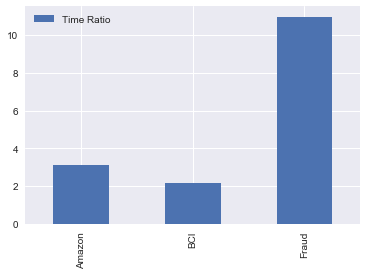

In [160]:
results_df[['Time Ratio']].plot(kind='bar');

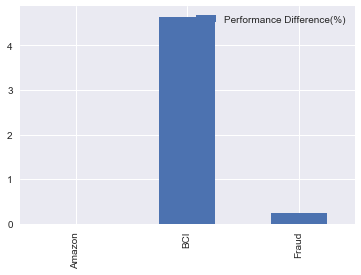

In [161]:
results_df[['Performance Difference(%)']].plot(kind='bar');

From the table as well as the plots below we can see that overall the difference in performance is quite small. LightGBM though is 2 to over 10 times quicker than XGBoost.